In [1]:
import pandas as pd   
import numpy as np
import random
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 

In [2]:
### READ DATA ###

df = pd.read_csv('Punta_Salute_2009.csv', sep=';')
df = df.dropna()

print(df.shape)
df.head()

(8760, 3)


,Data,Ora solare,Livello P.Salute Canal Grande (cm)
0,01-gen-09,01:00,34.0
1,01-gen-09,02:00,37.0
2,01-gen-09,03:00,36.0
3,01-gen-09,04:00,29.0
4,01-gen-09,05:00,20.0


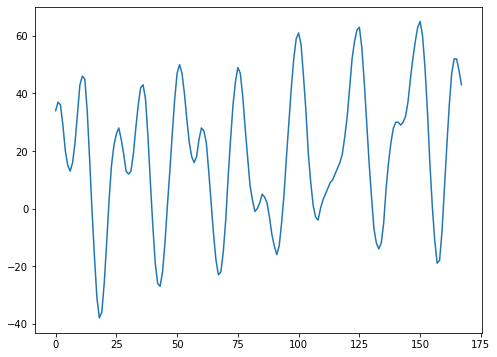

In [3]:
### PLOT WEEKLY TREND ###

df[:7*24]['Livello P.Salute Canal Grande (cm)'].plot(y='Livello P.Salute Canal Grande (cm)', x='Ora solare', figsize=(8,6))

In [4]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, input_dim=None, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(self.output_dim, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.B = self.add_weight(name='B',
                                shape=(self.input_dim, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        self.b = self.add_weight(name='b',
                                shape=(self.input_dim, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        original = self.w * x + self.b
        x = K.repeat_elements(x, self.output_dim, -1)
        sin_trans = K.sin(K.dot(x, self.W) + self.B)
        return K.concatenate([sin_trans,original], -1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim+1)

In [5]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [6]:
### DEFINE MODEL STRUCTURES ###

def T2V_NN(dim, t2v_dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(t2v_dim, dim)(inp)
    x = LSTM(32)(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam')
    
    return m

def NN(dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(32)(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam')
    
    return m

In [7]:
### PREPARE DATA TO FEED MODELS ###

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [8]:
### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

In [9]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### FIT T2V + LSTM ###

nnT2V = T2V_NN(sequence_length, 128)

nnT2V.fit(X_train, y_train, epochs=100, batch_size=1024, verbose=2)

Epoch 1/100
6/6 - 1s - loss: 1719.5044
Epoch 2/100
6/6 - 1s - loss: 1703.5176
Epoch 3/100
6/6 - 1s - loss: 1687.2218
Epoch 4/100
6/6 - 1s - loss: 1665.8541
Epoch 5/100
6/6 - 1s - loss: 1630.9467
Epoch 6/100
6/6 - 1s - loss: 1582.3231
Epoch 7/100
6/6 - 1s - loss: 1512.8700
Epoch 8/100
6/6 - 1s - loss: 1442.2006
Epoch 9/100
6/6 - 1s - loss: 1392.9178
Epoch 10/100
6/6 - 1s - loss: 1353.3942
Epoch 11/100
6/6 - 1s - loss: 1320.4824
Epoch 12/100
6/6 - 1s - loss: 1293.1221
Epoch 13/100
6/6 - 1s - loss: 1270.7343
Epoch 14/100
6/6 - 1s - loss: 1252.2091
Epoch 15/100
6/6 - 1s - loss: 1236.0225
Epoch 16/100
6/6 - 1s - loss: 1221.3334
Epoch 17/100
6/6 - 1s - loss: 1208.2251
Epoch 18/100
6/6 - 1s - loss: 1195.7190
Epoch 19/100
6/6 - 1s - loss: 1184.0004
Epoch 20/100
6/6 - 1s - loss: 1172.5219
Epoch 21/100
6/6 - 1s - loss: 1161.5648
Epoch 22/100
6/6 - 1s - loss: 1150.7467
Epoch 23/100
6/6 - 1s - loss: 1140.0067
Epoch 24/100
6/6 - 1s - loss: 1129.5697
Epoch 25/100
6/6 - 1s - loss: 1119.0031
Epoch 26/

In [10]:
pred_t2v = nnT2V.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_t2v)

23.577358855744293

In [11]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### FIT SIMPLE LSTM ###

nn = NN(sequence_length)

nn.fit(X_train, y_train, epochs=100, batch_size=1024, verbose=2)

Epoch 1/100
6/6 - 0s - loss: 1675.5297
Epoch 2/100
6/6 - 0s - loss: 1661.0952
Epoch 3/100
6/6 - 0s - loss: 1646.8849
Epoch 4/100
6/6 - 0s - loss: 1631.9625
Epoch 5/100
6/6 - 0s - loss: 1615.9996
Epoch 6/100
6/6 - 0s - loss: 1598.7291
Epoch 7/100
6/6 - 0s - loss: 1579.5508
Epoch 8/100
6/6 - 0s - loss: 1557.6079
Epoch 9/100
6/6 - 0s - loss: 1534.3239
Epoch 10/100
6/6 - 0s - loss: 1510.6676
Epoch 11/100
6/6 - 0s - loss: 1486.5415
Epoch 12/100
6/6 - 0s - loss: 1463.8214
Epoch 13/100
6/6 - 0s - loss: 1442.5219
Epoch 14/100
6/6 - 0s - loss: 1422.6820
Epoch 15/100
6/6 - 0s - loss: 1404.7416
Epoch 16/100
6/6 - 0s - loss: 1387.9888
Epoch 17/100
6/6 - 0s - loss: 1372.5775
Epoch 18/100
6/6 - 0s - loss: 1357.6577
Epoch 19/100
6/6 - 0s - loss: 1343.9701
Epoch 20/100
6/6 - 0s - loss: 1331.4214
Epoch 21/100
6/6 - 0s - loss: 1319.7640
Epoch 22/100
6/6 - 0s - loss: 1308.7544
Epoch 23/100
6/6 - 0s - loss: 1298.1132
Epoch 24/100
6/6 - 0s - loss: 1287.8153
Epoch 25/100
6/6 - 0s - loss: 1277.6893
Epoch 26/

In [12]:
pred_nn = nn.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_nn)

25.275576354286272

# COMPARE RESULTS WITH BOOTSRAPPING

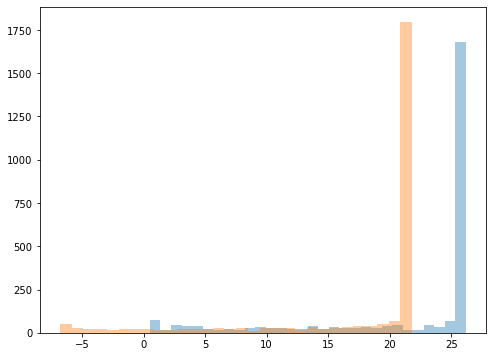

In [13]:
### PLOT PREDICTION DISTRIBUTIONS ###

plt.figure(figsize=(8,6))
plt.hist(pred_t2v, bins=30, alpha = 0.4)
plt.hist(pred_nn, bins=30, alpha = 0.4)

np.set_printoptions(False)

In [14]:
### BOOTSTRAPPED PREDICTION DISTRIBUTIONS ###

sample_t2v_pred = []
for _ in range(1000):
    sample_mean = np.random.choice(pred_t2v, 100).mean()
    sample_t2v_pred.append(sample_mean)

sample_nn_pred = []
for _ in range(1000):
    sample_mean = np.random.choice(pred_nn, 100).mean()
    sample_nn_pred.append(sample_mean)

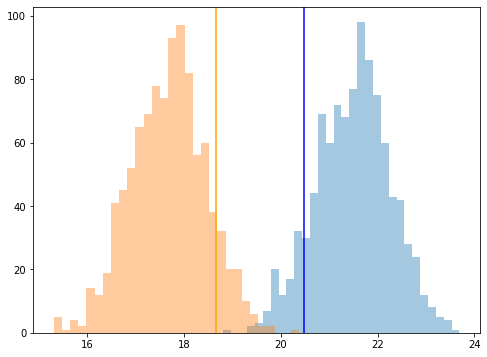

In [15]:
### PLOT BOOTSTRAPPED PREDICTION DISTRIBUTIONS ###

plt.figure(figsize=(8,6))
plt.hist(sample_t2v_pred, bins=30, alpha = 0.4)
plt.axvline(np.quantile(sample_t2v_pred, 0.1), c='blue')
plt.hist(sample_nn_pred, bins=30, alpha = 0.4)
plt.axvline(np.quantile(sample_nn_pred, 0.9), c='orange')

np.set_printoptions(False)